<a href="https://colab.research.google.com/github/GMAvaliani/intern/blob/main/%D0%9F%D0%B0%D1%86%D0%B8%D0%B5%D0%BD%D1%82_1_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%98%D0%A1%D0%A5%D0%9E%D0%94%D0%9D%D0%AB%D0%A5_%D0%94%D0%90%D0%9D%D0%9D%D0%AB%D0%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Загрузка Библиотек**

In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00


In [2]:
# Импорт необходимых библиотек
import os
import pydicom
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from google.colab import drive

# Подключение Google Drive к текущей среде выполнения
drive.mount('/content/drive')

# Задание директории, где находятся DICOM файлы
INPUT_FOLDER = '/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001'

# Получение списка всех DICOM файлов в директории
dicom_files = [f for f in os.listdir(INPUT_FOLDER) if f.endswith('.dcm')]

# Сортировка списка DICOM файлов
dicom_files.sort()


# Получение списка пациентов (файлов) в директории входных данных
patients = os.listdir(INPUT_FOLDER)
# Сортировка списка пациентов
patients.sort()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Читаю и вывожу файл DICOM**

In [3]:
# проверка содержимого списка patients
print(patients)

['09-18-2008-StudyID-NA-69331', '1-1.dcm']


In [4]:
import pydicom

# Указываем путь к файлу DICOM пациент LUNG1-001
dicom_file_path = '/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046/1-003.dcm'

# Читаем файл DICOM
ds = pydicom.dcmread(dicom_file_path)

# Выводим содержимое файла DICOM
print(ds)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.32722.99.99.106464456875572292175554838571095963812
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.1

## **Загрузка слайсов легкого из папки отдельного пациента с файлами DICOM**

In [5]:
def load_scan(path):
    # Считываем все DICOM файлы в указанной папке и создаем список slices
    # Элементы списка представляют собой объекты DICOM, которые содержат метаданные и пиксельные данные скана
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path) if s.endswith('.dcm')]

    # Если в slices меньше двух элементов, выводим сообщение об ошибке и прерываем выполнение функции
    if len(slices) < 2:
        print("Not enough DICOM files in the directory")
        return []

    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    # Устанавливаем толщину среза для всех срезов
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

## **Преобразование пиксельных значений в Hounsfield Units (HU)**

In [6]:

# Некоторые сканеры имеют цилиндрические границы сканирования, но выходное изображение квадратное.
# Пиксели, выходящие за эти границы, получают фиксированное значение -2000.
# Первым шагом будет установка этих значений в 0, что в настоящее время соответствует air.
# Затем давайте вернемся к единицам измерения HU, умножив наклон масштаба и добавив перехват (так удобнее хранить в метаданных сканов).

# Эта функция берет список срезов (slices), преобразует их в трехмерный массив,
# затем конвертирует значения пикселей из исходных значений в единицы Hounsfield (HU).
# Единицы Hounsfield используются в компьютерной томографии
# для количественной интерпретации плотности различных тканей

# Функция преобразования пикселей изображения в Hounsfield Units (HU)
def get_pixels_hu(scans):
    # Создаем 3D массив, объединяя все 2D изображения (pixel_array) из slices
    image = np.stack([s.pixel_array for s in scans])

    # Преобразуем тип данных изображения к int16
    # Это возможно, поскольку значения пикселей обычно меньше 32k
    image = image.astype(np.int16)

    # Устанавливаем пиксели за пределами сканирования равными 0
    # Пересечение обычно равно -1024, поэтому воздух будет примерно 0
    image[image == -2000] = 0

    # Преобразуем пиксели в единицы Hounsfield (HU)
    # При этом используются коэффициенты масштабирования и сдвига из метаданных DICOM файла
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    # Если коэффициент масштабирования не равен 1, применяем масштабирование
    # и затем приводим тип данных к int16
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    # Добавляем смещение к изображению
    image += np.int16(intercept)

    # Возвращаем обработанное изображение в виде массива np.int16
    return np.array(image, dtype=np.int16)

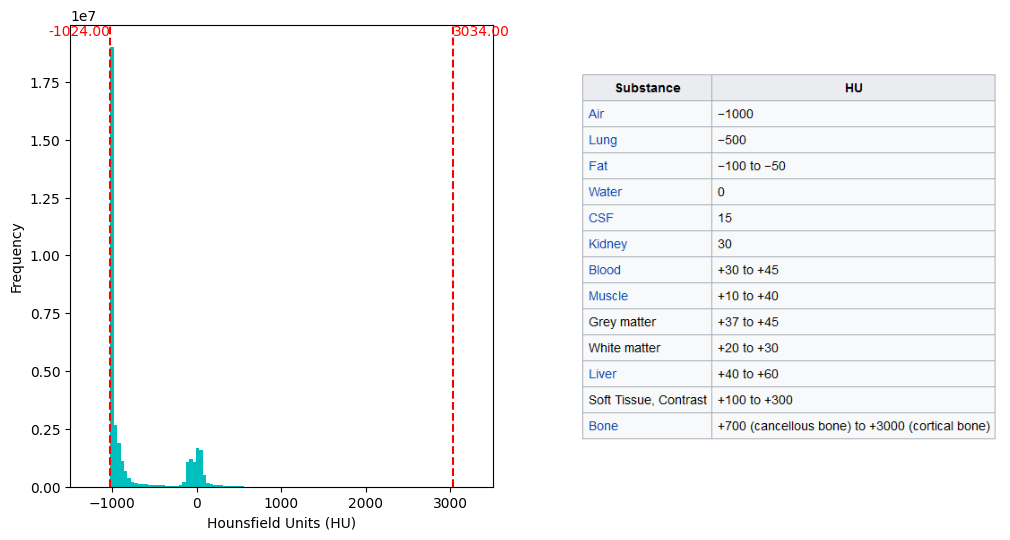

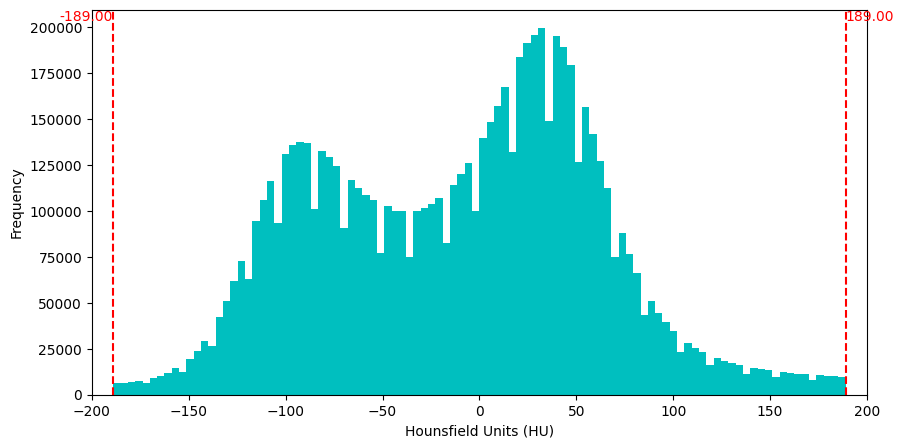

Транссудат от +2 до +15
Экссудат от +4 до +33


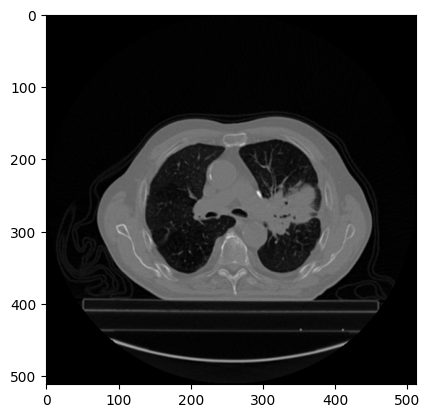

In [42]:
# Этот код загружает CT сканы первого пациента из списка, преобразует их в единицы Hounsfield (HU),
# строит гистограмму распределения пикселей по HU, затем отображает один из срезов (80-й срез) на экране


from PIL import Image
import matplotlib.pyplot as plt

# Загрузка сканов первого пациента из списка. Возвращает список slices
first_patient = load_scan('/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046')

# Преобразование пикселей изображения в единицы Hounsfield (HU) для первого пациента
first_patient_pixels = get_pixels_hu(first_patient)

# Создание объекта figure для отображения двух графиков (гистограммы и изображения) рядом
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Построение гистограммы распределения пикселей по единицам Hounsfield (HU)
n, bins, patches = ax[0].hist(first_patient_pixels.flatten(), bins=100, color='c')  # Создание гистограммы с 100 столбцами и цветом 'cian' (голубой)

ax[0].set_xlabel("Hounsfield Units (HU)")  # Название оси x
ax[0].set_ylabel("Frequency")  # Название оси y

# Пороговые значения
left_limit = -1500
right_limit = 3500
ax[0].set_xlim(left_limit, right_limit)  # Установка лимитов для оси x

# Отображение границных значений на самых крайних столбцах слева и справа
left_bin = bins[0]
right_bin = bins[-1]
ax[0].axvline(left_bin, color='r', linestyle='--')  # Вертикальная линия на крайнем левом столбце
ax[0].axvline(right_bin, color='r', linestyle='--')  # Вертикальная линия на крайнем правом столбце
ax[0].text(left_bin, ax[0].get_ylim()[1], f'{left_bin:.2f}', color='r', ha='right', va='top')  # Подпись на крайнем левом столбце
ax[0].text(right_bin, ax[0].get_ylim()[1], f'{right_bin:.2f}', color='r', ha='left', va='top')  # Подпись на крайнем правом столбце


# Загрузка и отображение изображения PNG
image_path = '/content/drive/MyDrive/HU From Wikipedia.png'  # путь к изображению
image = Image.open(image_path)
ax[1].imshow(image)
ax[1].axis('off')  # Выключаем отображение осей на втором графике


# Создание объекта figure для отображения гистограммы ВЫПОТА , а имеено, для пикселей со значениями, большими 2 и меньшими 33
fig, ax = plt.subplots(figsize=(10, 5))

# Построение гистограммы для пикселей, значения которых больше 2 и меньше 33
image_masked = first_patient_pixels[(first_patient_pixels > -190 ) & (first_patient_pixels < 190)]  # Создаем маску для пикселей
n, bins, patches = ax.hist(image_masked.flatten(), bins=100, color='c')  # Создаем гистограмму

ax.set_xlabel("Hounsfield Units (HU)")  # Название оси x
ax.set_ylabel("Frequency")  # Название оси y

# Пороговые значения
left_limit = -200
right_limit = 200
ax.set_xlim(left_limit, right_limit)  # Установка лимитов для оси x

# Отображение границных значений на самых крайних столбцах слева и справа
left_bin = bins[0]
right_bin = bins[-1]
ax.axvline(left_bin, color='r', linestyle='--')  # Вертикальная линия на крайнем левом столбце
ax.axvline(right_bin, color='r', linestyle='--')  # Вертикальная линия на крайнем правом столбце
ax.text(left_bin, ax.get_ylim()[1], f'{left_bin:.2f}', color='r', ha='right', va='top')  # Подпись на крайнем левом столбце
ax.text(right_bin, ax.get_ylim()[1], f'{right_bin:.2f}', color='r', ha='left', va='top')  # Подпись на крайнем правом столбце

plt.show()  # Отображение графика

print("Транссудат от +2 до +15")
print("Экссудат от +4 до +33")

# Показываю некоторый номер среза ниже
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)  # Отображение 80-го среза в сером цвете
plt.show()  # Отображение изображения


## **Ресэмплирование скана для получения изоморфного разрешения**

In [8]:
"""
значения пикселей имеют постоянное значение радиоплотности по всему набору данных путем преобразования в единицы Хаунсфилда,
важно также убедиться, что каждый пиксель представляет собой единый объем по всему набору данных
Заголовок DICOM включает атрибут PixelSpacing, который содержит измерения x и y в миллиметрах (x-spacing и y-spacing).
Расстояние по оси z (краниокаудальное расстояние) может быть определено путем вычитания значений положения по оси z соседних срезов, указанных в ImagePositionPatient.
В совокупности расстояния (x,y,z) указывают на физический объем в кубических миллиметрах, который представляет собой один воксель (воксель - это трехмерный пиксель).
К сожалению, эти физические расстояния зависят от параметров сканирования, поэтому физический размер каждого вокселя у разных пациентов различен.
Кроме того, расстояние между точками (x,y) часто отличается от расстояния между точками (z) при одном сканировании
функцию scipy.ndimage.interpolation.zoom для изменения размера изображения. Эта функция принимает фактор изменения размера и изменяет размер изображения с использованием интерполяции ближайшего соседа (mode='nearest')
"""

# Сканирование может иметь разные расстояние между пикселями.Это в свою очередь будет влиять на расстояние между срезами снимков.
# Mетодом решения этой проблемы является повторная выборка всего набора данных для достижения одинаковых свойств пространства по всем направлениям
# Если сделать Resampling до пикселей размером 1мм x 1мм x 1мм, то мы сможем использовать 3D-сверточные сети,
# не беспокоясь о том, чтобы обучить их

def resample(image, scan, new_spacing=[1,1,1]):

  # image - входное изображение, которое требуется изменить с использованием метода ресемплирования


    # Определение текущего разрешения пикселей
    # scan[0].SliceThickness - это толщина слайса, scan[0].PixelSpacing - это пространственное разрешение (ширина и высота пикселя)
    # Мы добавляем их вместе и преобразуем в список, чтобы обеспечить корректную работу
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))  # Преобразование в numpy массив

    # Вычисление фактора изменения размера на основе текущего и нового пространственного разрешения
    resize_factor = spacing / new_spacing

    # Вычисляем новую форму изображения, умножая текущую форму на фактор изменения размера
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)  # Округление до ближайшего целого числа для получения корректной формы изображения

    # Вычисление фактора реального изменения размера на основе округленной формы
    real_resize_factor = new_shape / image.shape

    # Вычисление нового пространственного разрешения на основе фактора реального изменения размера
    new_spacing = spacing / real_resize_factor

    # Изменение размера изображения с использованием интерполяции ближайшего соседа для сохранения оригинальных значений пикселей
    """
    функция scipy.ndimage.interpolation.zoom для изменения размера изображения. Эта функция принимает фактор изменения размера и изменяет размер изображения с использованием интерполяции ближайшего соседа (mode='nearest')
    """
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    # Возвращаем измененное изображение и новое пространственное разрешение
    return image, new_spacing


In [9]:
# Функция resample изменяет размер изображения, так чтобы расстояние между пикселями стало одинаковым по всем трем измерениям

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])

# исходное изображение в виде трехмерного массива - first_patient_pixels
# first_patient - список слайсов, содержащих информацию о разрешении пикселей
# [1,1,1] - новое разрешение пикселей в миллиметрах, которое вы хотите установить для изображения


# Здесь мы просто печатаем форму изображения до и после ресемплирования
print("Shape before resampling\t", first_patient_pixels.shape)  # \t означает табуляцию, это просто добавляет немного отступа между строкой и выводом
print("Shape after resampling\t", pix_resampled.shape)

<ipython-input-8-ece24470a4e7>:45: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (134, 512, 512)
Shape after resampling	 (402, 500, 500)


## **Проверка статистических характеристик**

In [10]:
first_patient = load_scan('/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046')
image = get_pixels_hu(first_patient)

"""
 Сравниваем статистические характеристики (минимальное, максимальное, среднее значения и стандартное отклонение) исходного и измененного изображений
 """


print("Original image stats:")
print("Min:", np.min(image)) # здесь image - это ваше исходное изображение в виде numpy массива
print("Max:", np.max(image))
print("Mean:", np.mean(image))
print("Standard deviation:", np.std(image))


print("\nResampled image stats:")
print("Min:", np.min(pix_resampled)) # здесь resampled_image - это  преобразованное изображение в виде numpy массива
print("Max:", np.max(pix_resampled))
print("Mean:", np.mean(pix_resampled))
print("Standard deviation:", np.std(pix_resampled))




Original image stats:
Min: -1024
Max: 3034
Mean: -741.3879128925836
Standard deviation: 426.958591508985

Resampled image stats:
Min: -1281
Max: 3202
Mean: -741.3772816616915
Standard deviation: 426.7224927512853


## **Визуализация скана в 3D**

In [11]:
# Создадим 3D визуализацию изображения на основе заданного порогового значения
# Используем библиотеку Matplotlib для построения и библиотеку scikit-image для обработки изображений

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

def plot_3d(image, threshold=-300):
    """
    Эта функция создает 3D визуализацию изображения на основе заданного порогового значения.
    Параметры:
    image: ndarray
        3D массив, представляющий изображение.
    threshold: float, необязательный
        Пороговое значение, используемое для создания 3D модели. По умолчанию равно -300.
    """
    # Расположим сканирование вертикально,
    # так чтобы голова пациента была вверху, лицом к камере
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]

    # Получаем вершины и грани 3D модели, используя marching_cubes
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    # Создаем объект Figure в matplotlib и добавляем в него 3D подзаголовок
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

        # Создаем коллекцию треугольников из вершин и граней, устанавливаем цвет и прозрачность, добавляем в подзаголовок
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    # Устанавливаем границы для каждой оси в соответствии с формой транспонированного изображения
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    # Отображаем визуализацию
    plt.show()


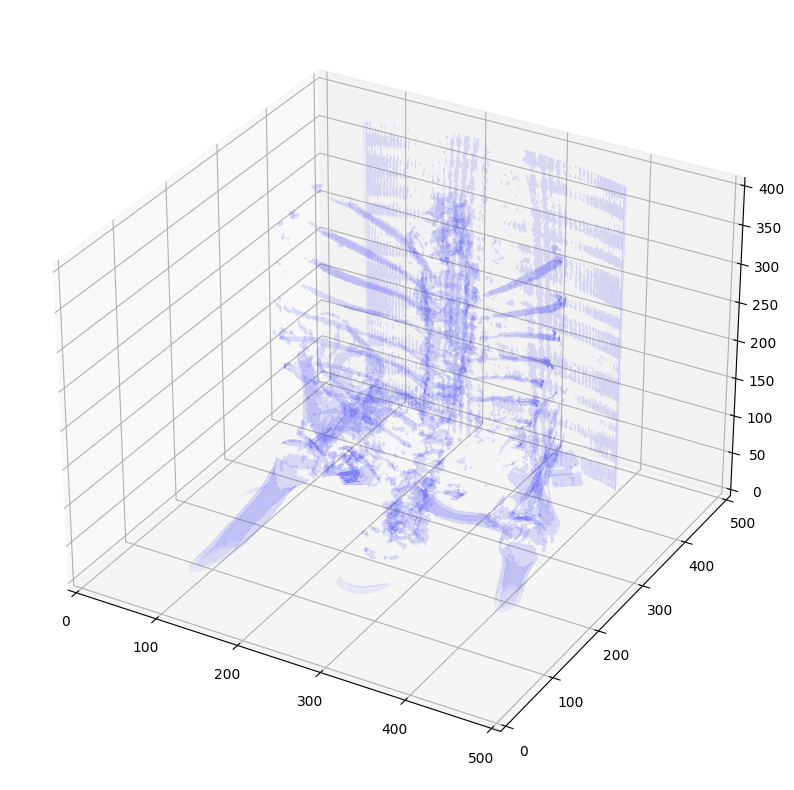

In [12]:
plot_3d(pix_resampled, 400)

# визуализация ПОСЛЕ resample

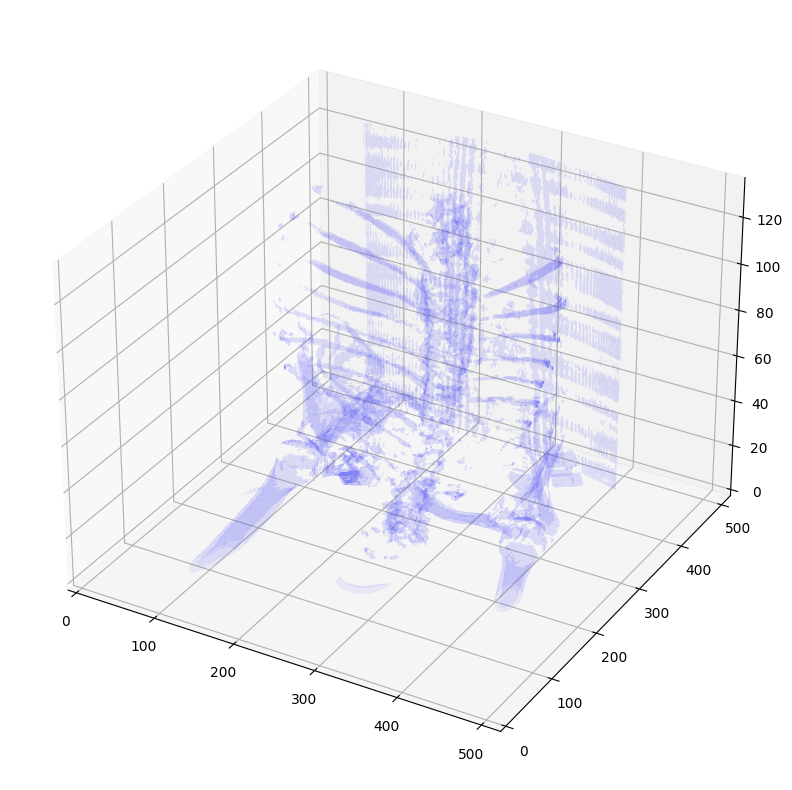

In [23]:
plot_3d(image, 400)

# Ниже визуализация ДО resample

## **Сегментация легких**

In [13]:
"""
проведем сегментацию легких

Шаги:

1.Пороговая обработка изображения (-320 HU - хороший порог, но для этого подхода это не имеет большого значения)
2. Определим метку воздуха вокруг человека, заполним эту область единицами
3. Для каждого аксиального среза определяем наибольшую связную компоненту (тело + воздух вокруг человека) и устанавливаем остальные на 0. Это заполняет структуры в легких на маске.
Этот шаг говорит о том, что для каждого горизонтального среза ищем наибольшую область, которая связана вместе.
Это будет включать в себя тело человека и воздух вокруг него. Затем устанавливаем все остальные области (которые не являются частью этой наибольшей области) равными нулю.
Это позволяет нам "заполнить" области внутри легких на нашей маске, то есть мы помечаем их как часть легких.

4.Оставляем только наибольший воздушный карман
Тело человека содержит множество воздушных карманов или полостей, не только легкие.
Под воздушными карманами понимаются пространства, заполненные воздухом.
 Это помогает нам исключить другие воздушные полости из нашей маски легких.

"""

import numpy as np
from skimage import measure

def largest_label_volume(im, bg=-1):
    """
    Эта функция находит метку наибольшего объема на изображении, исключая фон.
    Параметры:
    im: ndarray
        3D массив, представляющий изображение.
    bg: int, необязательный
        Значение, используемое для представления фона на изображении. По умолчанию равно -1.
    """
    # Вычисляем уникальные значения и их количество на изображении
    vals, counts = np.unique(im, return_counts=True)

    # Исключаем фон из рассмотрения
    counts = counts[vals != bg]
    vals = vals[vals != bg]

    # Если на изображении есть какие-либо метки, возвращаем метку наибольшего объема,
    # в противном случае возвращаем None
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def segment_lung_mask(image, fill_lung_structures=True):
    """
    Эта функция создает маску для легких на изображении.
    Параметры:
    image: ndarray
        3D массив, представляющий изображение.
    fill_lung_structures: bool, необязательный
        Если True, то внутренние структуры легких заполняются. По умолчанию True.
    """
    # Создаем бинарное изображение, где 1 и 2 - это объекты, а 0 - это фон

    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    # Выбираем пиксель в самом углу, чтобы определить, какая метка является воздухом.
    background_label = labels[0,0,0]

    # Заполняем воздух вокруг персоны
    binary_image[background_label == labels] = 2

    # Если мы хотим заполнить структуры легких
    if fill_lung_structures:
        # Для каждого среза определяем наибольшую сплошную структуру
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            # Если этот срез содержит некоторую легкую структуру
            if l_max is not None:
                binary_image[i][labeling != l_max] = 1


    # Преобразуем изображение в фактическое бинарное
    binary_image -= 1
    # Инвертируем его, теперь легкие обозначаются 1
    binary_image = 1-binary_image

    # Удаляем другие воздушные карманы внутри тела
    labels = measure.label


In [14]:
# В этом блоке кода мы используем функцию segment_lung_mask для сегментации легких на изображении.

# В первом случае мы применяем функцию без заполнения внутренних структур легких (fill_lung_structures=False)
# Это означает, что внутри контура легких могут быть воздушные карманы или другие структуры.
segmented_lungs = segment_lung_mask(pix_resampled, False)

# Во втором случае мы применяем функцию с заполнением внутренних структур легких (fill_lung_structures=True)
# Это означает, что все пространство внутри контура легких будет считаться частью легких.
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)


## **Визуализация структур внутри лёгких**

In [15]:
# Операция вычитания между типом None и числом невозможна.
# ПРОВЕРКА. Приниает ли переменная segmented_lungs_fill или segmented_lungs значение None.
# Если одна из переменных segmented_lungs или segmented_lungs_fill равна None, увидим сообщение об ошибке

segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

if segmented_lungs is not None and segmented_lungs_fill is not None:
    plot_3d(segmented_lungs_fill - segmented_lungs, 0)
else:
    print("Ошибка: segmented_lungs или segmented_lungs_fill равен None")


Ошибка: segmented_lungs или segmented_lungs_fill равен None


Адаптируем код для сегментации Transudate и Exudate по определенным значениям на шкале Hounsfield

In [16]:
# Задание директории, где находятся DICOM файлы
INPUT_FOLDER = '/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046'

slices = load_scan(INPUT_FOLDER)
try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
print("Slice thickness: ", slice_thickness)


Slice thickness:  3.0


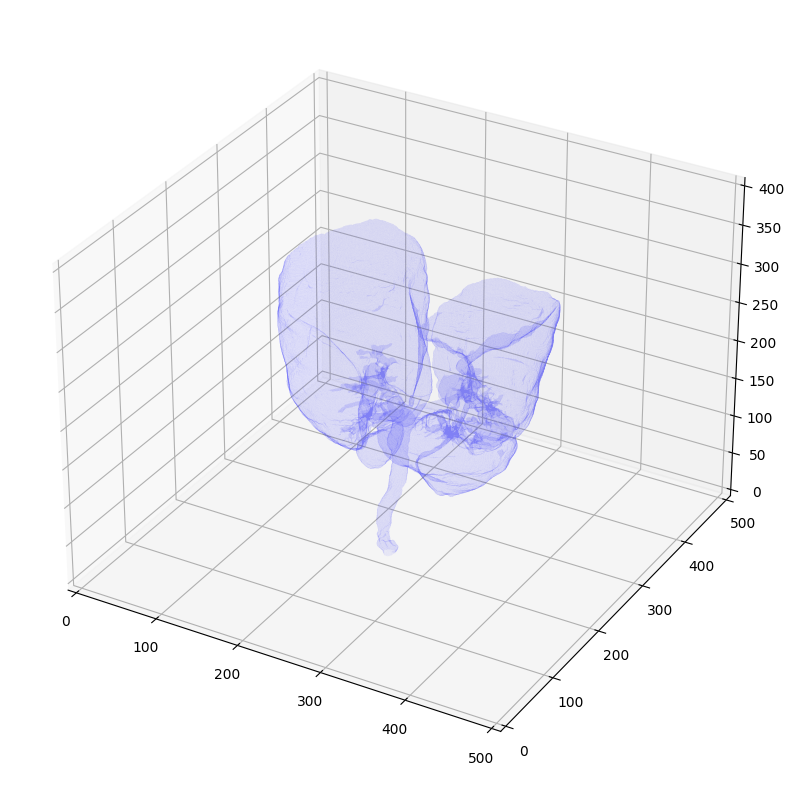

In [17]:
"""
функция get_pixels_hu(scans) используется для получения сырых данных изображения в формате, который можно интерпретировать и анализировать.
Затем эти данные могут быть обработаны и сегментированы (например, с использованием функции segment_lung_mask()), и largest_label_volume(im, bg=-1)
может быть использована для идентификации и извлечения определенных структур (выпота) из сегментированного изображения.
"""
import os
import pydicom
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Определение функции load_scan()
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

# Определение функции get_pixels_hu()
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0

    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    return np.array(image, dtype=np.int16)

# Определение функции resample()
def resample(image, scan, new_spacing=[1, 1, 1]):
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape).astype(int)
    real_resize_factor = new_shape / image.shape
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

# Определение функции largest_label_volume()
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

# Определение функции segment_lung_mask()

def segment_lung_mask(image, fill_lung_structures=True):
    binary_image = np.array(image > -320, dtype=np.int8) + 1  # Здесь создается двоичное изображение, где пиксели с единицами Hounsfield больше -320 устанавливаются равными 1, а все остальные равны 0. Затем к этому изображению добавляется 1, чтобы получить значения 1 и 2 вместо 0 и 1.

    labels = measure.label(binary_image) # Это метка связанных компонентов в двоичном изображении. То есть, каждая отдельная группа связанных пикселей (т.е. пикселей, которые "касаются" друг друга) получает уникальный идентификатор (метку).
    background_label = labels[0, 0, 0] # Здесь мы получаем метку фона, предполагая, что пиксель в углу изображения (0,0,0) является фоном.
    binary_image[background_label == labels] = 2 # Здесь мы устанавливаем все пиксели фона равными 2.
    if fill_lung_structures:  # Если истина, то заполняем структуры легких.
        for i, axial_slice in enumerate(binary_image): # Перебираем все осевые срезы в двоичном изображении.
            axial_slice = axial_slice - 1 # Вычитаем 1 из каждого осевого среза, чтобы вернуться к значениям 0 и 1.
            labeling = measure.label(axial_slice) # Снова маркируем связные компоненты.
            l_max = largest_label_volume(labeling, bg=0) # Находим метку компонента с наибольшим объемом, исключая фон.
            if l_max is not None:
                binary_image[i][labeling != l_max] = 1 # Если есть компоненты кроме фона и наибольшего компонента, устанавливаем их равными 1.
    binary_image -= 1  # Вычитаем 1 из всех пикселей, чтобы вернуться к значениям 0 и 1.

    binary_image = 1 - binary_image # Инвертируем изображение
    labels = measure.label(binary_image, background=0) # Снова маркируем связные компоненты
    l_max = largest_label_volume(labels, bg=0) # находим метку компонента с наибольшим объемом, исключая фон
    if l_max is not None:
        binary_image[labels != l_max] = 0 # Если есть компоненты кроме фона и наибольшего компонента, устанавливаем их равными 0
    return binary_image # Возвращаем окончательное двоичное изображение, где легкие обозначены как 1, а все остальное как 0

# Определение функции plot_3d()
def plot_3d(image, threshold=-300):
    p = image.transpose(2, 1, 0)
    p = p[:, :, ::-1]
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()


# Задание директории, где находятся DICOM файлы
INPUT_FOLDER = '/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046'

# Получение сканов первого пациента
first_patient = load_scan(INPUT_FOLDER)

# Получение пикселей изображения в единицах Hounsfield (HU) для первого пациента
first_patient_pixels = get_pixels_hu(first_patient)

# Получение отресэмплированного изображения
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])

# Сегментация областей легких
segmented_lungs = segment_lung_mask(pix_resampled)

# Визуализация сегментированных областей легких
plot_3d(segmented_lungs, threshold=0)



## Сегментируем **выпот**

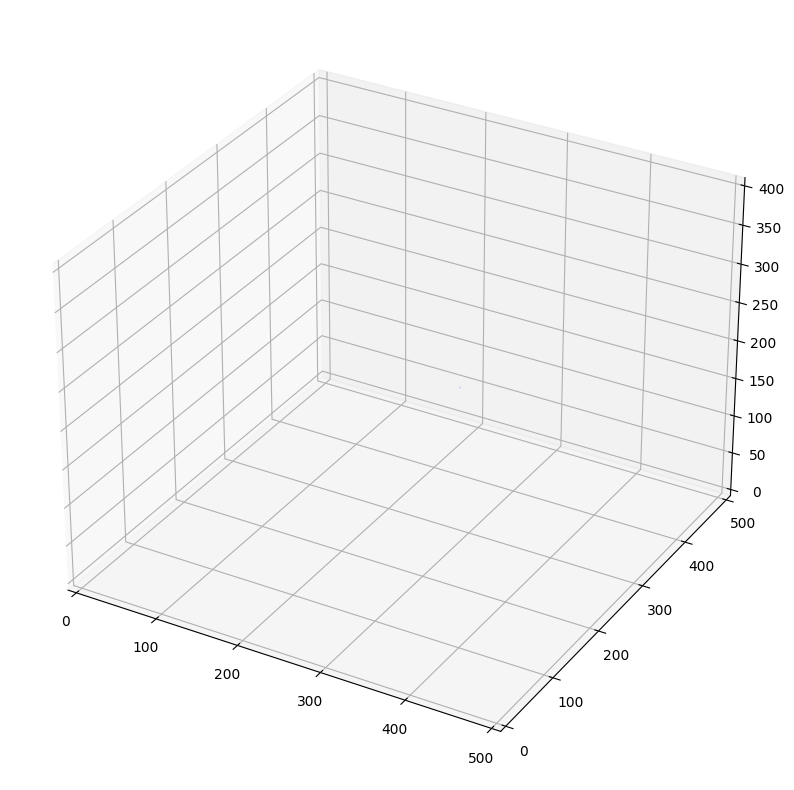

In [18]:
"""
функция get_pixels_hu(scans) используется для получения сырых данных изображения в формате, который можно интерпретировать и анализировать.
Затем эти данные могут быть обработаны и сегментированы (например, с использованием функции segment_lung_mask()), и largest_label_volume(im, bg=-1)
может быть использована для идентификации и извлечения определенных структур (выпота) из сегментированного изображения.
"""
import os
import pydicom
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Определение функции load_scan()
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

# Определение функции get_pixels_hu()
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0

    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    return np.array(image, dtype=np.int16)

# Определение функции resample()
def resample(image, scan, new_spacing=[1, 1, 1]):
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape).astype(int)
    real_resize_factor = new_shape / image.shape
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

# Определение функции largest_label_volume()
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

# Определение функции segment_lung_mask()

"""
Если fill_lung_structures=True, алгоритм заполнит все пиксели внутри области, идентифицированной как легкие, значением 1.
Это означает, что все внутренние структуры легких, включая бронхи, сосуды и возможные опухоли, будут "заполнены" и не будут видны на визуализации,
 потому что все будет иметь одно и то же значение пикселя.

Если fill_lung_structures=False, алгоритм не заполняет внутренние структуры легких. Это означает, что структуры внутри легких,
 которые не являются частью основной ткани легких, будут иметь различные значения пикселей, отличные от 1.
 Следовательно, они будут видны на визуализации, потому что они будут иметь отличные от основной ткани легких значения пикселей.
"""

# Здесь создается двоичное изображение, где пиксели с единицами Hounsfield в интервале от +2 до +33  устанавливаются равными 1, а все остальные равны 0. Затем к этому изображению добавляется 1, чтобы получить значения 1 и 2 вместо 0 и 1.
"""
Здесь оператор > используется для сравнения каждого пикселя изображения с значением -320.
Если пиксель больше -320, то он считается "истинным" или "1". Если пиксель меньше или равен -320, то он считается "ложным" или "0".
После этого к каждому пикселю добавляется 1, чтобы получить бинарное изображение с значениями 1 и 2 вместо 0 и 1.

Все пиксели с HU больше -320 считаются частью легких (или другой интересующей нас области),
а все пиксели с HU меньше или равны -320 считаются фоном или нежелательными областями
"""
def segment_lung_mask(image, fill_lung_structures=False):
    binary_image = np.array((image > 2) & (image < 33), dtype=np.int8) + 1

 # Это метка связанных компонентов в двоичном изображении. То есть, каждая отдельная группа связанных пикселей (т.е. пикселей, которые "касаются" друг друга) получает уникальный идентификатор (метку)
    labels = measure.label(binary_image)
    # Здесь мы получаем метку фона, предполагая, что пиксель в углу изображения (0,0,0) является фоном.
    background_label = labels[0, 0, 0]
        # Здесь мы устанавливаем все пиксели фона равными 2
    binary_image[background_label == labels] = 2
    # Если истина, то заполняем структуры легких
    if fill_lung_structures:
      # Перебираем все осевые срезы в двоичном изображении
        for i, axial_slice in enumerate(binary_image):
          # Вычитаем 1 из каждого осевого среза, чтобы вернуться к значениям 0 и 1
            axial_slice = axial_slice - 1
            # Снова маркируем связные компоненты
            labeling = measure.label(axial_slice)
            # Находим метку компонента с наибольшим объемом, исключая фон
            l_max = largest_label_volume(labeling, bg=0)
            if l_max is not None:
              # Если есть компоненты кроме фона и наибольшего компонента, устанавливаем их равными 1.
                binary_image[i][labeling != l_max] = 1
    # Вычитаем 1 из всех пикселей, чтобы вернуться к значениям 0 и 1
    binary_image -= 1
    # Инвертируем изображение
    binary_image = 1 - binary_image
    labels = measure.label(binary_image, background=0) # Снова маркируем связные компоненты
    l_max = largest_label_volume(labels, bg=0) # находим метку компонента с наибольшим объемом, исключая фон
    if l_max is not None:
        binary_image[labels != l_max] = 0 # Если есть компоненты кроме фона и наибольшего компонента, устанавливаем их равными 0
    return binary_image # Возвращаем окончательное двоичное изображение, где легкие обозначены как 1, а все остальное как 0

# Определение функции plot_3d()
def plot_3d(image, threshold=+1):    #При установке порогового значения в 1, будут отображаться только пиксели с значениями Hounsfield (HU), которые превышают 1.
# Пиксели с значениями HU меньше или равными 1 будут считаться фоном или неинтересной областью и не будут отображаться.
    p = image.transpose(2, 1, 0)
    p = p[:, :, ::-1]
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()


# Задание директории, где находятся DICOM файлы
INPUT_FOLDER = '/content/drive/MyDrive/AI_стажировка/Текущий проект/Исходные данные/Исходный датасет/manifest-1586193031612/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046'

# Получение сканов первого пациента
first_patient = load_scan(INPUT_FOLDER)

# Получение пикселей изображения в единицах Hounsfield (HU) для первого пациента
first_patient_pixels = get_pixels_hu(first_patient)

# Получение отресэмплированного изображения
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])

# Сегментация областей легких
segmented_lungs = segment_lung_mask(pix_resampled)

# Визуализация сегментированных областей легких
plot_3d(segmented_lungs, threshold=0)

In [19]:
print(segmented_lungs.shape)

unique_values, counts = np.unique(segmented_lungs, return_counts=True)
print(unique_values)
print(counts)


print(segmented_lungs)


(402, 500, 500)
[0 1]
[100499996         4]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


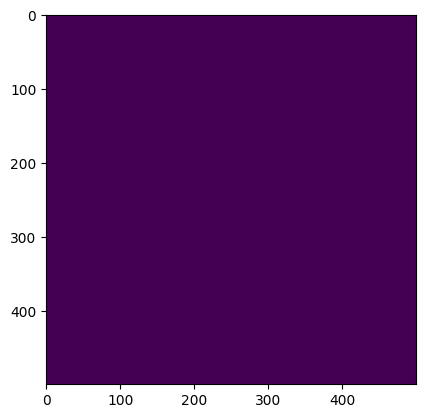

In [20]:
plt.imshow(segmented_lungs[100])  # Показать поперечное сечение на позиции 100
plt.show()


In [21]:
# путь к папке, где сохраняются результаты сегментации segmented_lungs

import os
print(os.getcwd())

print(os.path.abspath("segmented_lungs"))


/content
/content/segmented_lungs


## **Нормализация значений пикселей**

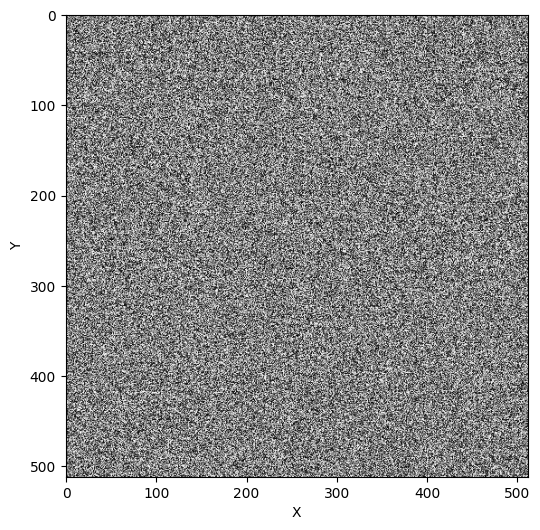

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Предположим, что first_patient_pixels - это ваша двумерная матрица изображения в формате int16
first_patient_pixels = np.random.randint(low=-1000, high=400, size=(512, 512), dtype=np.int16)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(first_patient_pixels, cmap='gray')  # Отображение исходного изображения
ax.set_xlabel("X")  # Название оси x
ax.set_ylabel("Y")  # Название оси y

plt.show()
